# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

Our task is to predict which recipes will be popular 80% of the time and minimize the
chance of showing unpopular recipes in the homepage. These are the important tasks which need to be answered:
- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

**Step 1: Data Validation**

Data preproccessing

In [211]:
# Libraries

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as snn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline

plt.style.use("ggplot")

In [212]:
# Start coding here...
import pandas as pd
df = pd.read_csv("recipe_site_traffic_2212.csv", index_col="recipe")

Shape of dataframe

In [213]:
print(df.shape)

(947, 7)


In the dataset, we have 947 rows and 7 columns

Looking at first 10 rows of dataset 

In [214]:
# Looking on 1st 10 rows
df.head(10)

,calories,carbohydrate,sugar,protein,category,servings,high_traffic
recipe,,,,,,,
1,NaN,NaN,NaN,NaN,Pork,6,High
2,35.48,38.56,0.66,0.92,Potato,4,High
3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
4,97.03,30.56,38.63,0.02,Beverages,4,High
5,27.05,1.85,0.80,0.53,Beverages,4,NaN
6,691.15,3.46,1.65,53.93,One Dish Meal,2,High
7,183.94,47.95,9.75,46.71,Chicken Breast,4,NaN
8,299.14,3.17,0.40,32.40,Lunch/Snacks,4,NaN
9,538.52,3.78,3.37,3.79,Pork,6,High


Checking datatypes of columns

In [215]:
df.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
high_traffic     object
dtype: object

According to dataset, all the datatypes seems correct accept servings as mostly it has int values but the datatype is object, lets figure out this column

In [216]:
df["servings"].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

As we can see 2 values are not int values, lets convert this column into "int"

In [217]:
df["servings"] = df["servings"].str.replace(" as a snack", "")

In [218]:
df["servings"].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

lets figure out traffic column

In [219]:
df["high_traffic"].head()

recipe
1    High
2    High
3     NaN
4    High
5     NaN
Name: high_traffic, dtype: object

In this column, we only have high and null values. It seems that the null values should be low traffic values.
Now we will replace null values with low traffic and change the column name to traffic

In [220]:
df["high_traffic"].fillna("Low", inplace = True)
df.rename(columns = {"high_traffic" : "traffic"}, inplace = True)
df["traffic"].value_counts()

High    574
Low     373
Name: traffic, dtype: int64

Now we will clean out data

Now will remove duplicate rows

In [221]:
print("Shape of dataset 'Before' removing dupliactes: ", df.shape)
df.drop_duplicates(inplace=True)
print("Shape of dataset 'After' removing dupliactes: ", df.shape)

Shape of dataset 'Before' removing dupliactes:  (947, 7)
Shape of dataset 'After' removing dupliactes:  (924, 7)


Almost 23 rows were duplicated and we removed them from the data.
Now we will handle missing data

Total missing values in each column

In [222]:
df.isna().sum().sort_values()

category         0
servings         0
traffic          0
calories        29
carbohydrate    29
sugar           29
protein         29
dtype: int64

Since the missing data is less than 5%, we will drop null values from the data

In [223]:
print("Percentage of missing data: ", (29 / 947) * 100)

Percentage of missing data:  3.062302006335797


In [224]:
dataset_with_null_values = df.copy()
df.dropna(inplace = True)

In [225]:
df.isna().sum()

calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
traffic         0
dtype: int64

Lets visualize outliers

<AxesSubplot: >

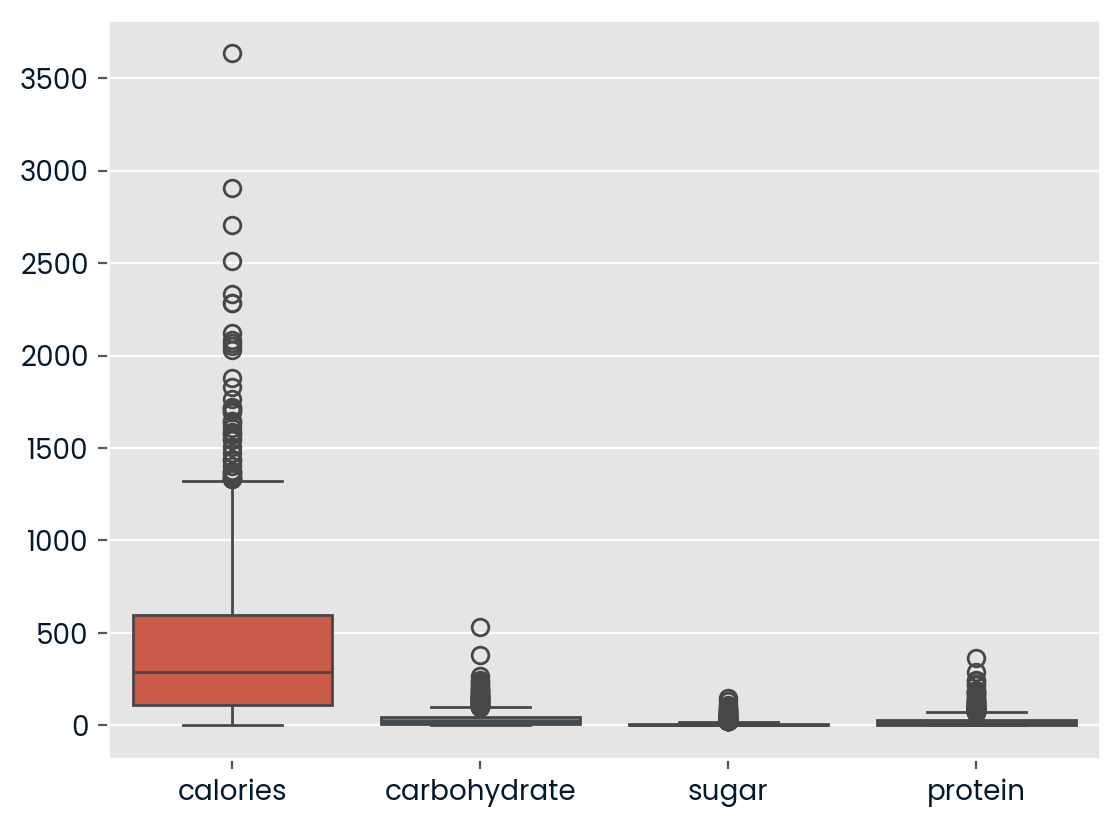

In [226]:
snn.boxplot(df)

We will remove outliers

In [227]:
def remove_outliers(df,col):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    IQR = Q3 - Q1
    upper = Q3 + (1.5 * IQR)
    lower = Q1 - (1.5 * IQR)
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

numeric_cols = df.select_dtypes(include = ["float64", "int64"])

for column in numeric_cols.columns:
    remove_outliers(df, column)

<AxesSubplot: >

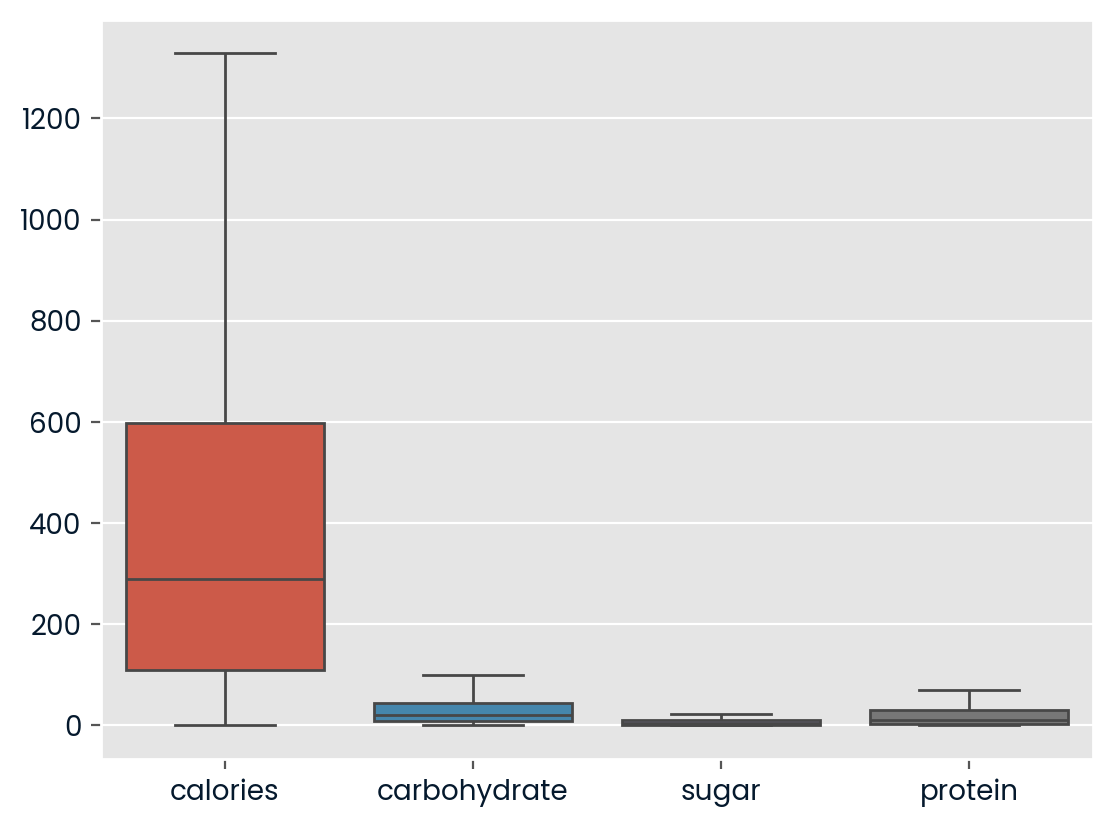

In [228]:
snn.boxplot(df)

**Step 2: Exploratory Data Analysis**

First 10 rows

In [229]:
df.head(10)

,calories,carbohydrate,sugar,protein,category,servings,traffic
recipe,,,,,,,
2,35.48,38.56,0.660,0.9200,Potato,4,High
3,914.28,42.68,3.090,2.8800,Breakfast,1,Low
4,97.03,30.56,21.965,0.0200,Beverages,4,High
5,27.05,1.85,0.800,0.5300,Beverages,4,Low
6,691.15,3.46,1.650,53.9300,One Dish Meal,2,High
7,183.94,47.95,9.750,46.7100,Chicken Breast,4,Low
8,299.14,3.17,0.400,32.4000,Lunch/Snacks,4,Low
9,538.52,3.78,3.370,3.7900,Pork,6,High
10,248.28,48.54,3.990,70.7075,Chicken,2,Low


Shape of data

In [230]:
df.shape

(895, 7)

Datatypes

In [231]:
df.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings         object
traffic          object
dtype: object

Statistics of data

In [232]:
df.describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,413.361665,31.083430,6.834866,20.124053
std,378.241095,28.945415,6.624471,22.111812
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,1328.480000,99.850000,21.965000,70.707500


Distribution of high and low traffic

In [233]:
df.traffic.value_counts() / df.traffic.count() * 100

High    59.776536
Low     40.223464
Name: traffic, dtype: float64

This data is somehow imbalance as 60% of the traffic is High and 40% is low

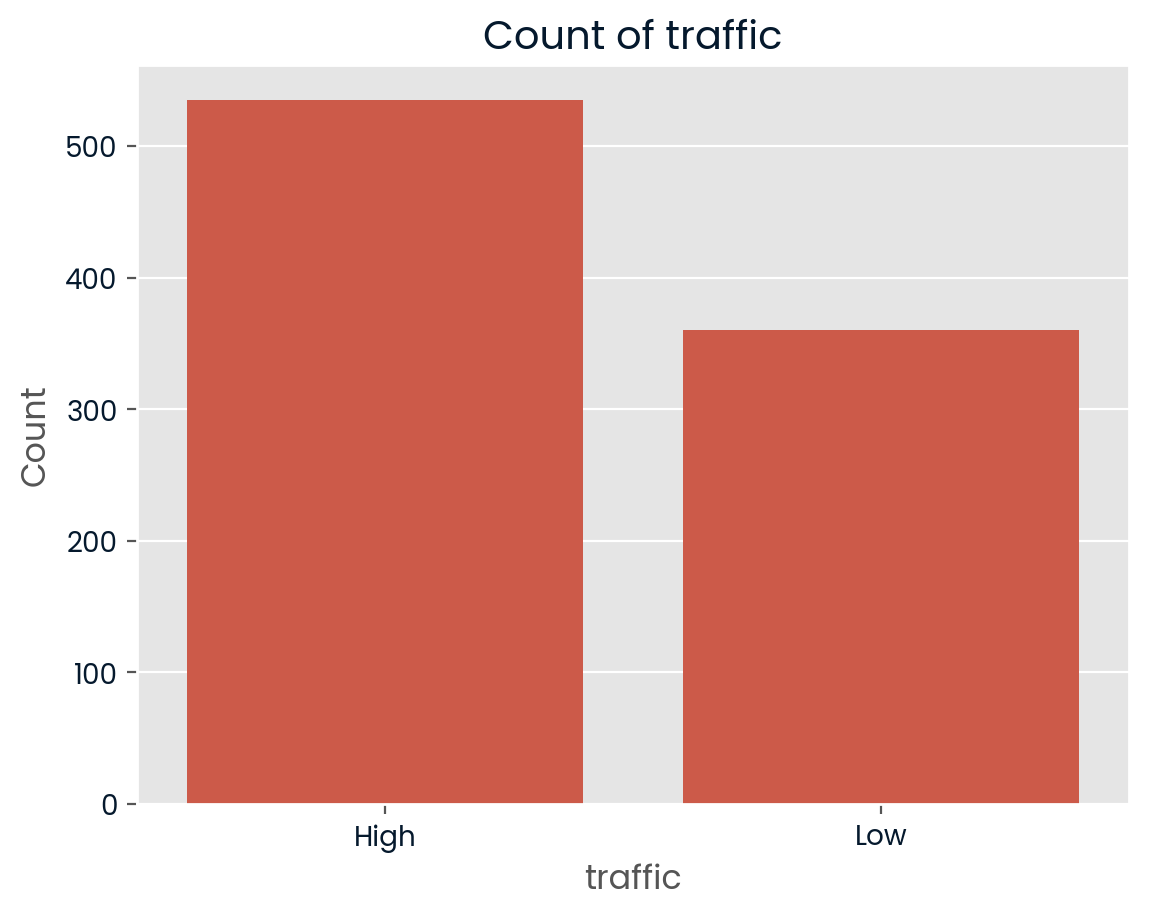

In [234]:
snn.countplot(df, x="traffic")
plt.title("Count of traffic")
plt.ylabel("Count")
plt.show()

Now we will see correlation of each numeric features

<AxesSubplot: >

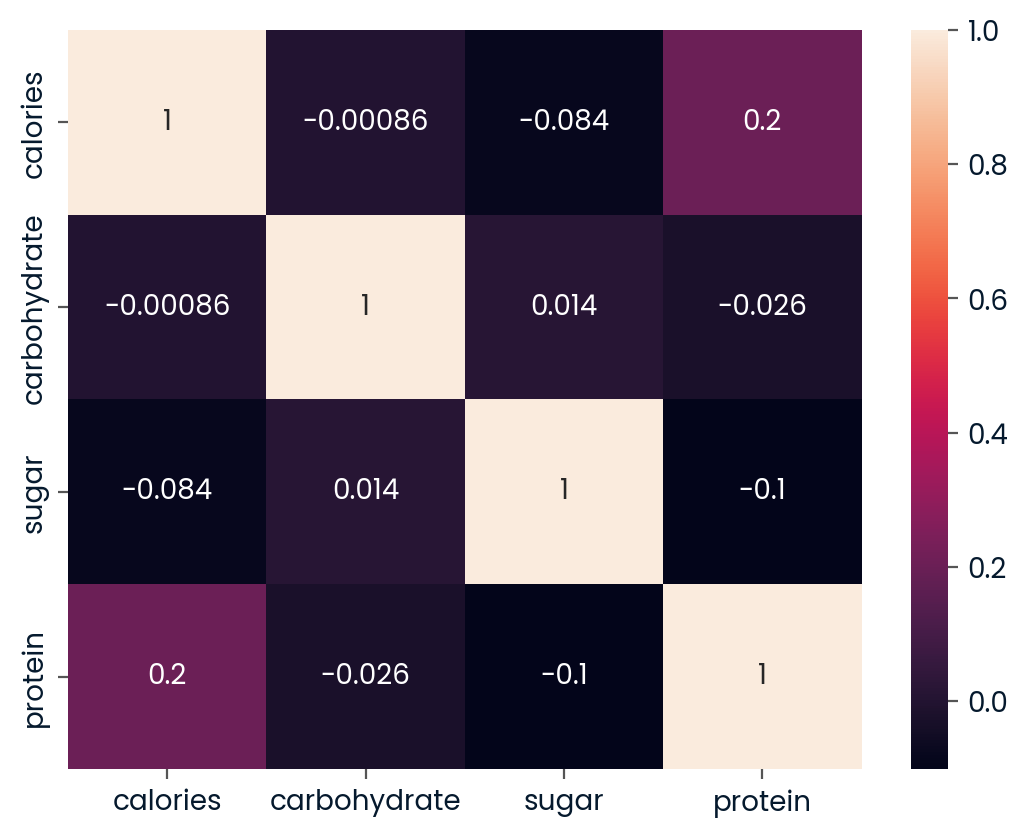

In [235]:
snn.heatmap(df.select_dtypes("number").corr(), annot = True)

The correlation is not very strong among features

Now we will visualize each traffic with numeric features

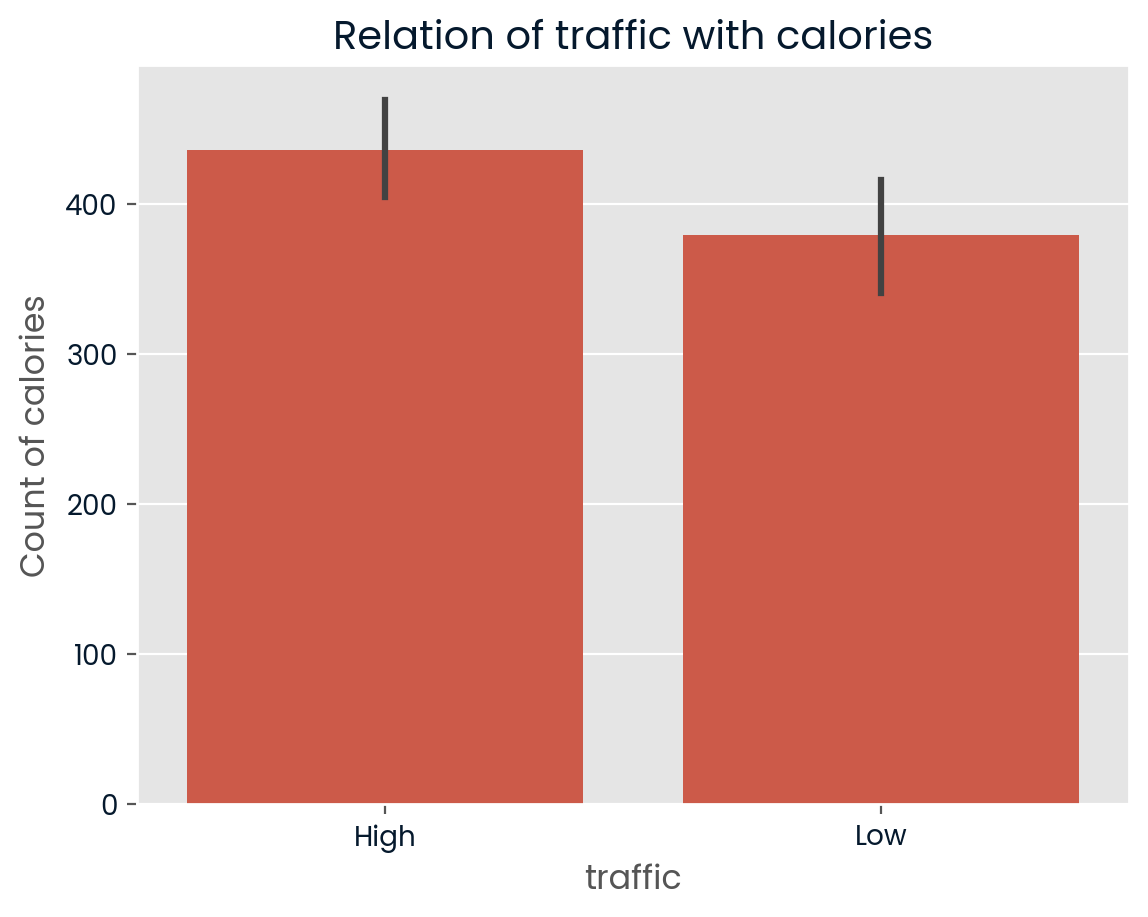

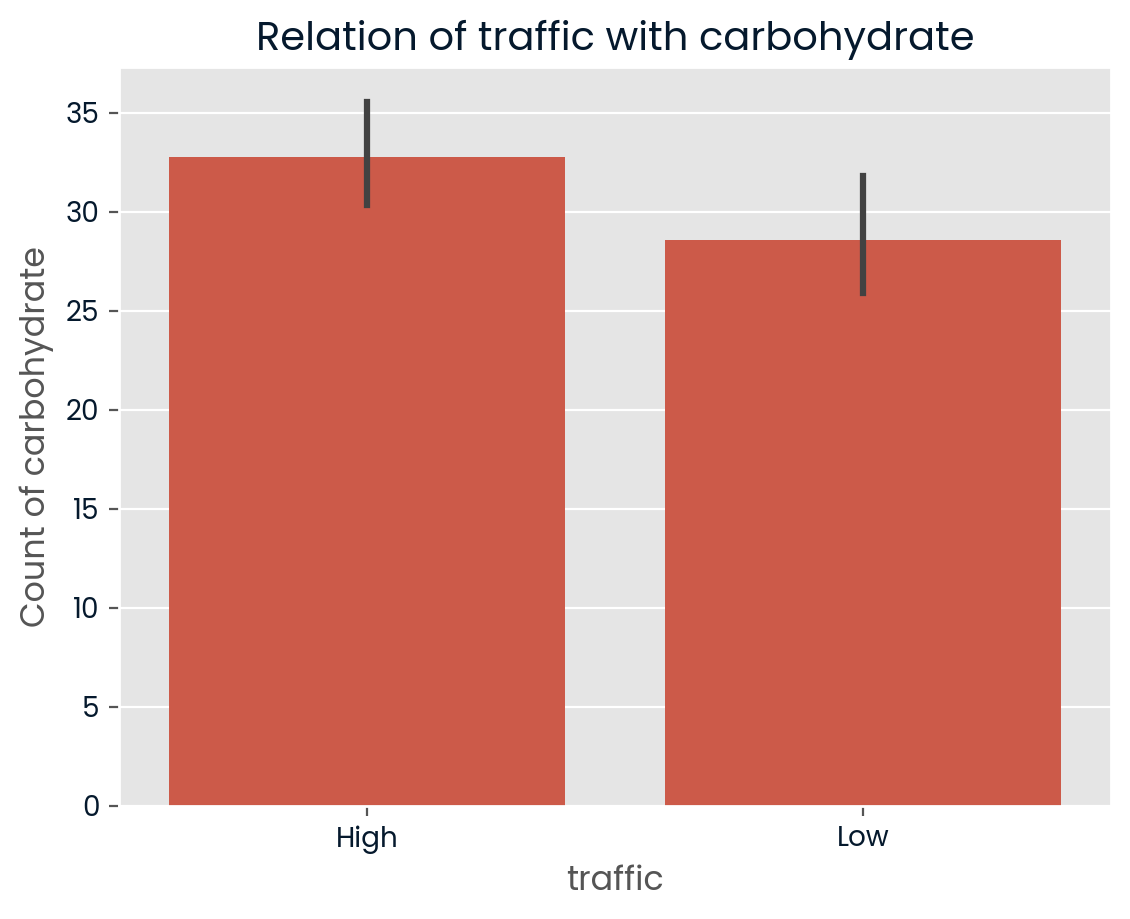

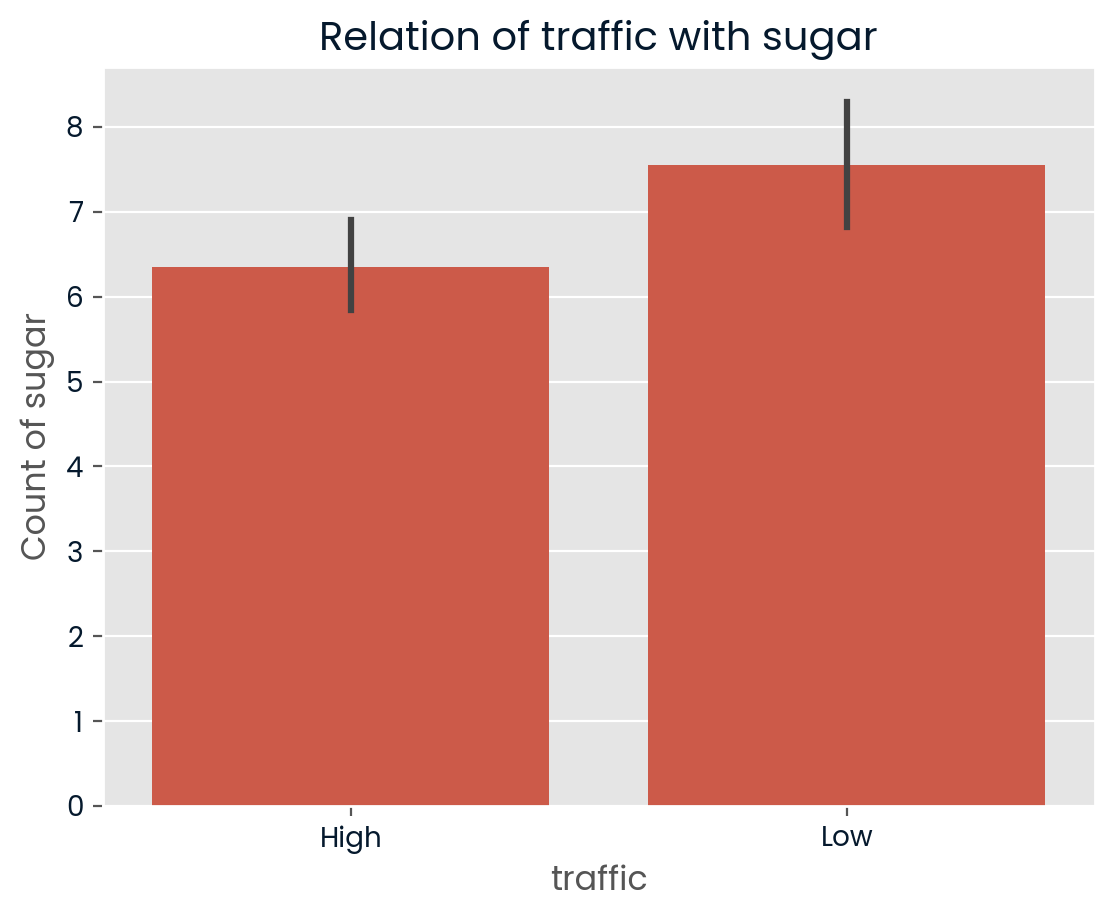

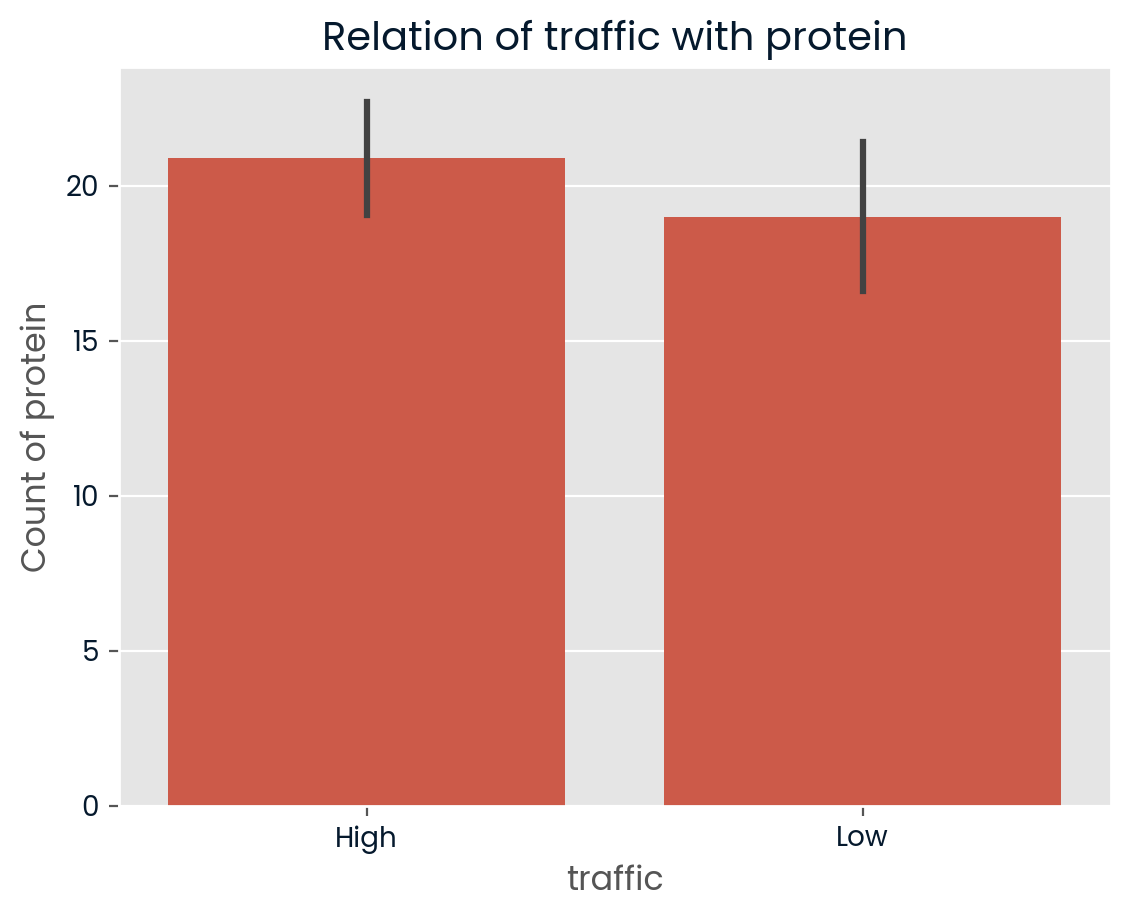

In [236]:
for column in df.select_dtypes("number"):
    snn.barplot(df, x = "traffic", y= column)
    plt.ylabel("Count of " + column)
    plt.title("Relation of traffic with " + column)
    plt.show()

From the above visualizations, we can conclude that the recipes with high sugat has 'Low' Traffic

Lets visualize this relation with scatterplot

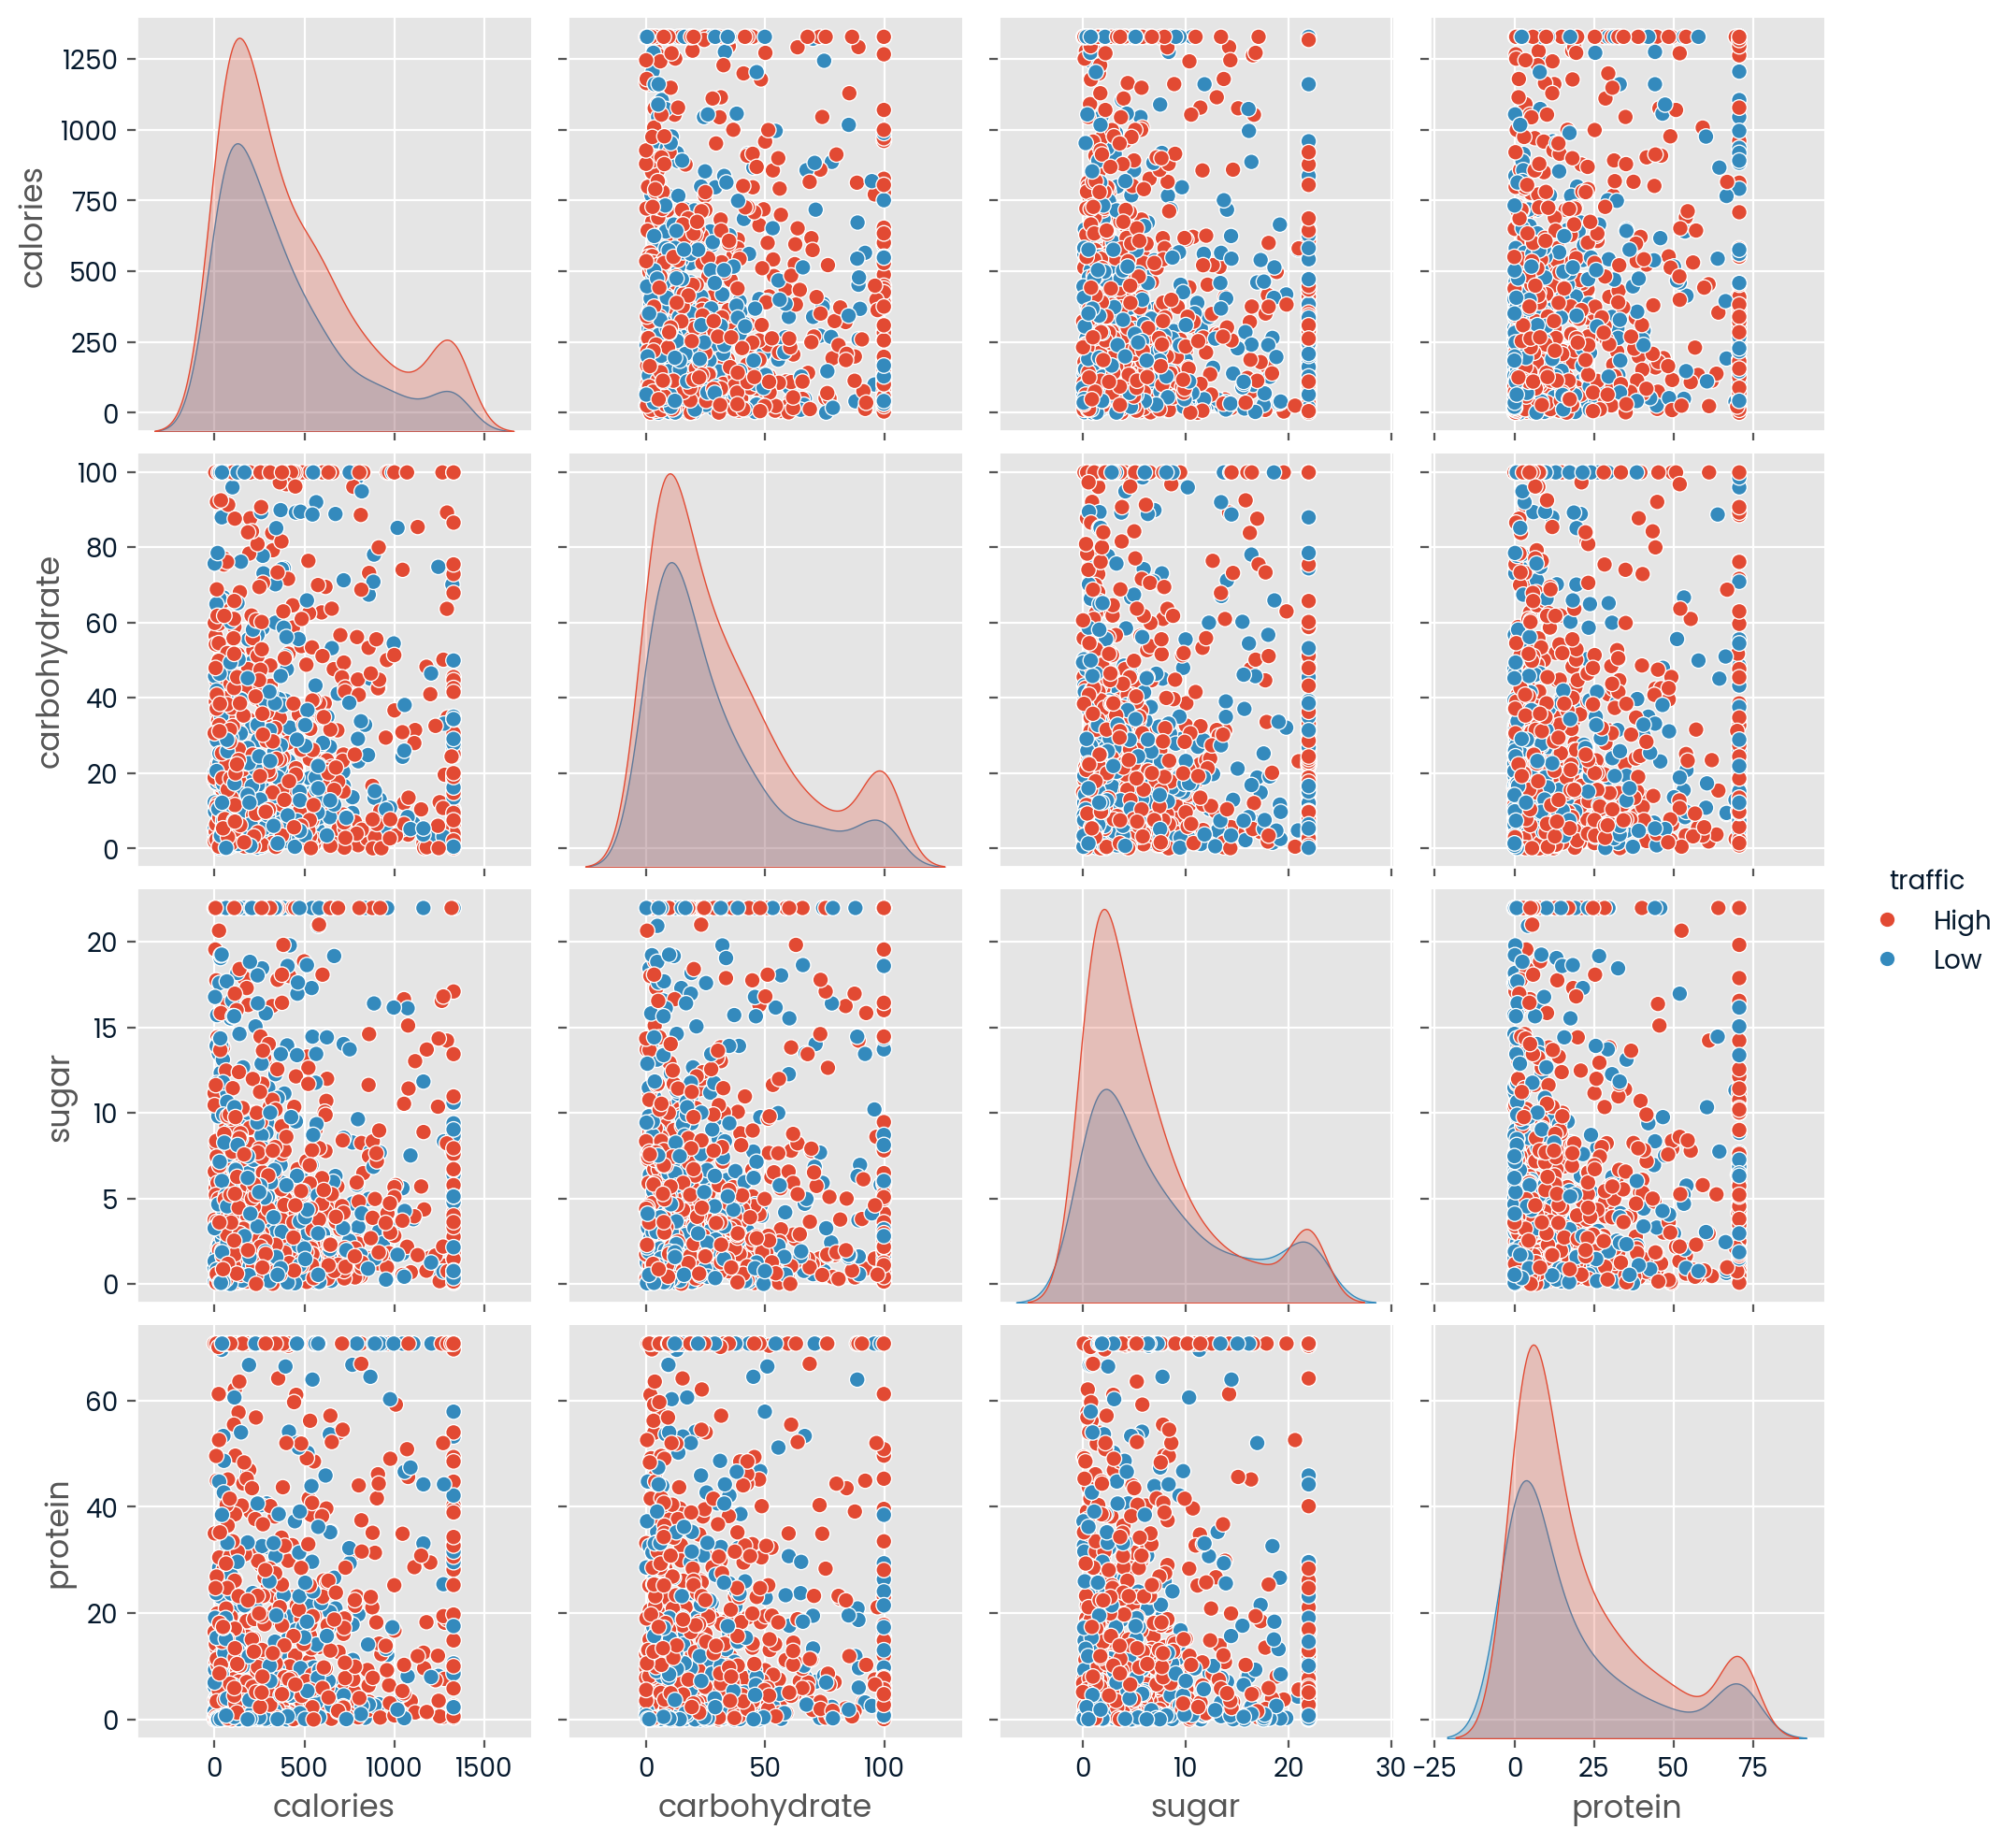

In [237]:
snn.pairplot(df.drop(columns="servings"), hue="traffic")
plt.show()

Now lets visualize categorical variables

In [238]:
df.category.value_counts()

Breakfast         106
Chicken Breast     94
Beverages          92
Potato             83
Lunch/Snacks       82
Vegetable          78
Dessert            77
Meat               74
Pork               73
Chicken            69
One Dish Meal      67
Name: category, dtype: int64

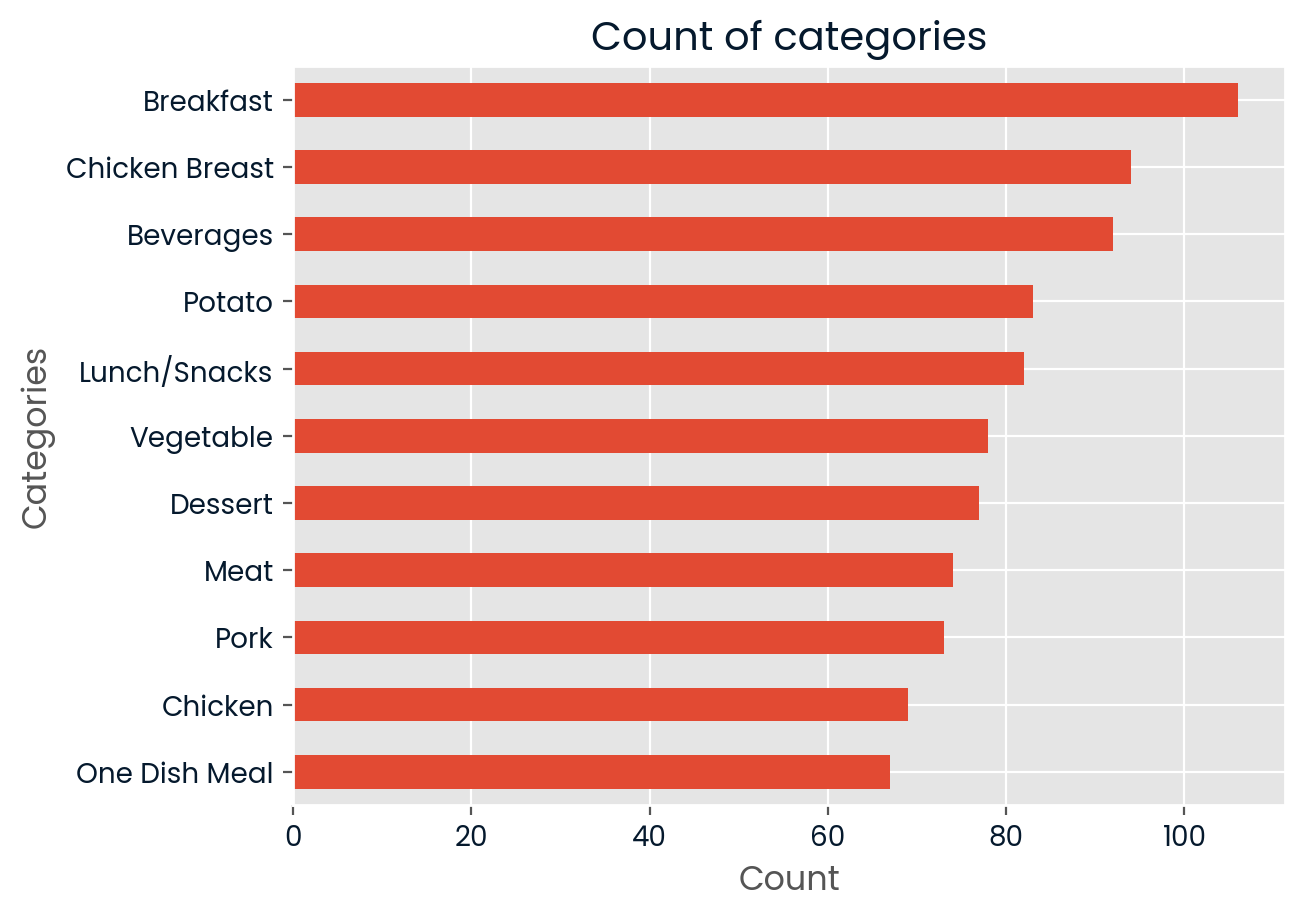

In [239]:
df.category.value_counts().sort_values(ascending=True).plot(kind = "barh")
plt.xlabel("Count")
plt.ylabel("Categories")
plt.title("Count of categories")
plt.show()

Breakfast is the most popular serving

Now we will visualize which serving has high count

In [240]:
df.servings = df.servings.astype(int)

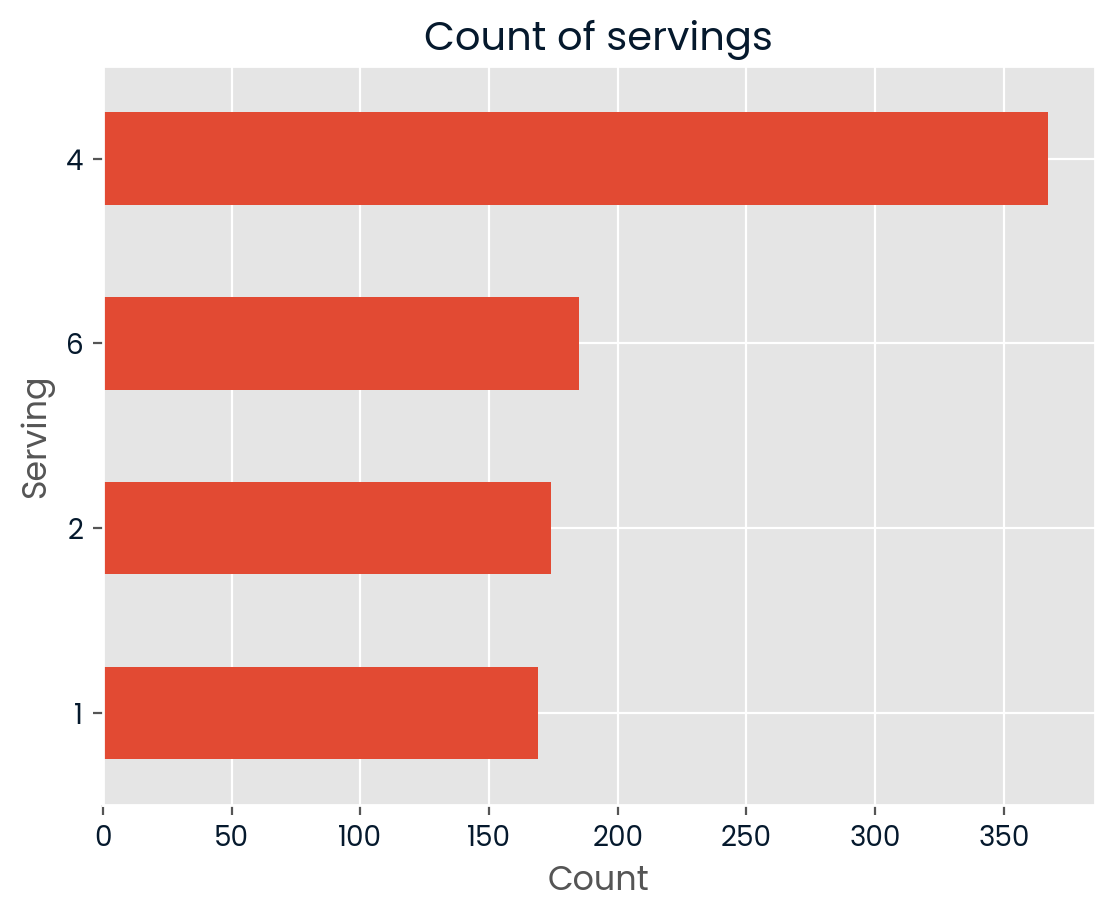

In [241]:
df.servings.value_counts().sort_values().plot(kind = "barh", xlabel = "Count", ylabel = "Serving"\
                                              , title = "Count of servings")
plt.show()

Serving 4 has the highest count

Lets check the relationship of traffic with servings and categories

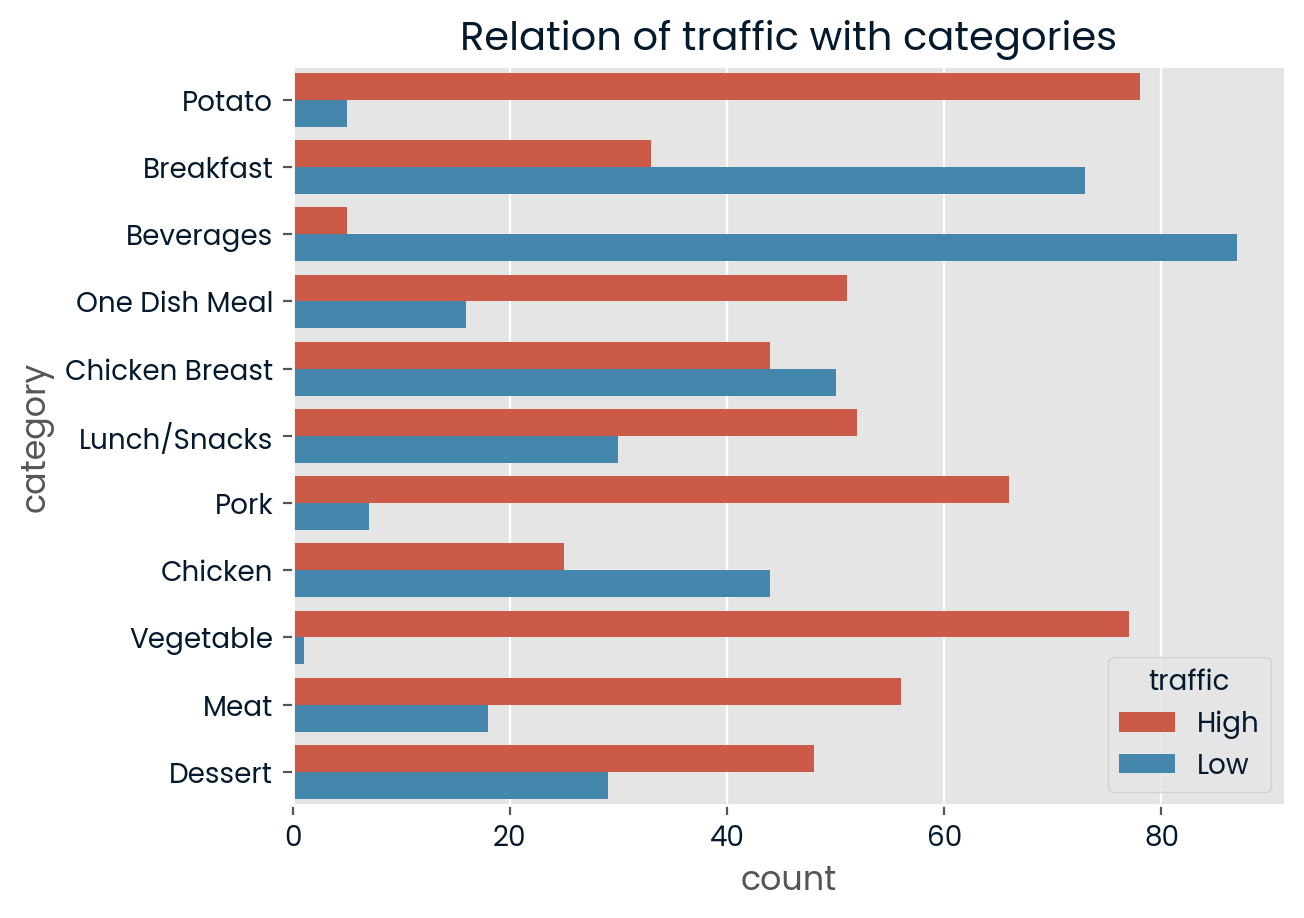

In [242]:
snn.countplot(data=df, y = "category", hue="traffic")
plt.title("Relation of traffic with categories")
plt.show()

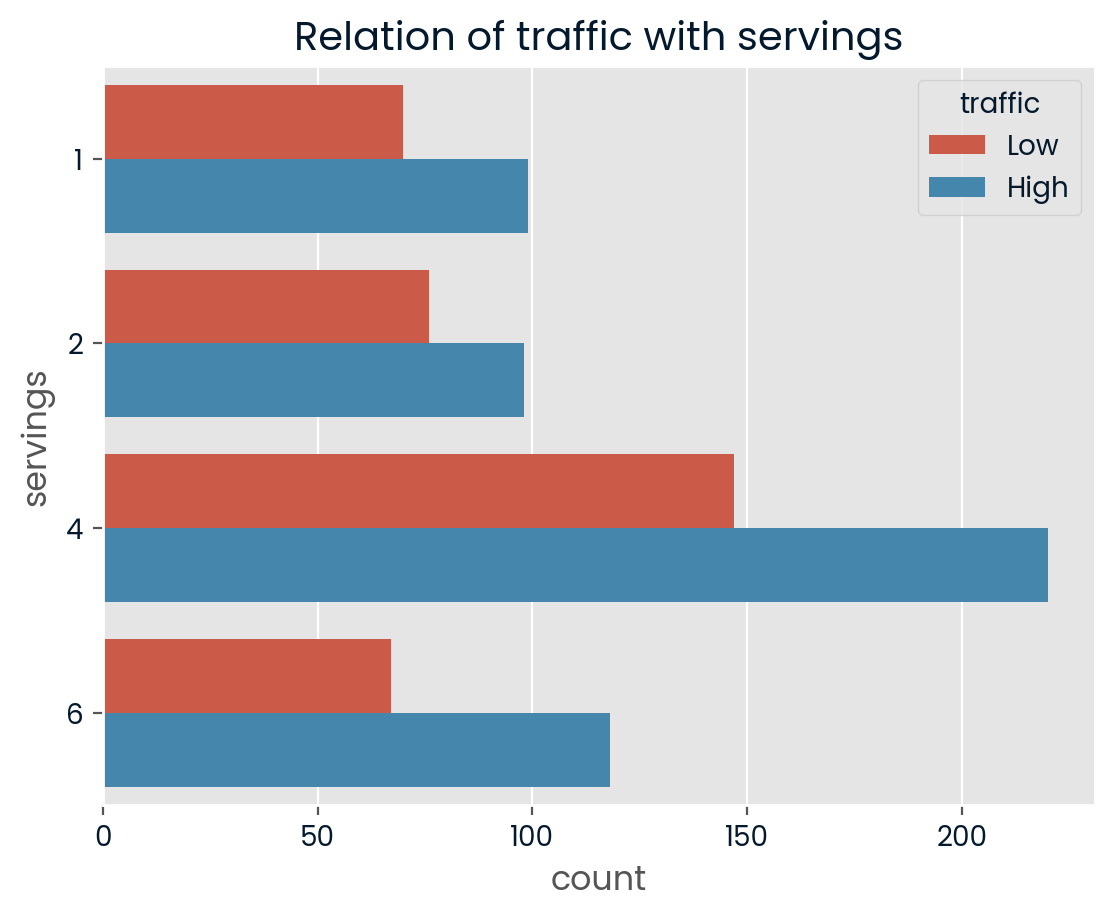

In [243]:
snn.countplot(data=df, y = "servings", hue="traffic")
plt.title("Relation of traffic with servings")
plt.show()

We are done with eda.
Now we will implement machine learning

In [244]:
df["traffic"] = (df["traffic"] == "High").astype(int)

In [245]:
df["traffic"].value_counts(normalize = True)

1    0.597765
0    0.402235
Name: traffic, dtype: float64

**Step3: Model Development**

Firstly we will implement logistic regression

Splitting the data

In [246]:
df.dtypes

calories        float64
carbohydrate    float64
sugar           float64
protein         float64
category         object
servings          int64
traffic           int64
dtype: object

I am going to do feature engineering

In [247]:
df = pd.get_dummies(df, columns=["category"])

In [248]:
numeric_cols = ['calories', 'carbohydrate', 'sugar', 'protein']
df["St_dev"] = df[numeric_cols].apply(lambda x: np.std(x), axis =1)
label_encoder = LabelEncoder()
df['traffic'] = label_encoder.fit_transform(df['traffic'])

In [249]:
df.head()

,calories,carbohydrate,sugar,protein,servings,traffic,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,St_dev
recipe,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.660,0.92,4,1,0,0,0,0,0,0,0,0,0,1,0,18.147933
3,914.28,42.68,3.090,2.88,1,0,0,1,0,0,0,0,0,0,0,0,0,389.210353
4,97.03,30.56,21.965,0.02,4,1,1,0,0,0,0,0,0,0,0,0,0,36.187104
5,27.05,1.85,0.800,0.53,4,0,1,0,0,0,0,0,0,0,0,0,0,11.264798
6,691.15,3.46,1.650,53.93,2,1,0,0,0,0,0,0,0,1,0,0,0,291.511236


In [250]:
new_order = ['calories',  'carbohydrate',   'sugar',  'protein','St_dev' , 'servings','category_Beverages'  ,'category_Breakfast' , 'category_Chicken' ,'category_Chicken Breast',  'category_Dessert' , 'category_Lunch/Snacks' ,'category_Meat',  'category_One Dish Meal',  'category_Pork',  'category_Potato', 'category_Vegetable' ,'traffic'] 
df = df[new_order]
df.head()

,calories,carbohydrate,sugar,protein,St_dev,servings,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,traffic
recipe,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.660,0.92,18.147933,4,0,0,0,0,0,0,0,0,0,1,0,1
3,914.28,42.68,3.090,2.88,389.210353,1,0,1,0,0,0,0,0,0,0,0,0,0
4,97.03,30.56,21.965,0.02,36.187104,4,1,0,0,0,0,0,0,0,0,0,0,1
5,27.05,1.85,0.800,0.53,11.264798,4,1,0,0,0,0,0,0,0,0,0,0,0
6,691.15,3.46,1.650,53.93,291.511236,2,0,0,0,0,0,0,0,1,0,0,0,1


In [251]:
X = df.drop(["traffic"], axis =1).values
y = df["traffic"].values

In [252]:
numeric = X[: , :5]

In [253]:
sc = StandardScaler()
sc.fit(numeric)
nf = sc.transform(numeric)


In [254]:
x = np.concatenate((numeric, X[:, 5:]), axis=1)

In [255]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (716, 17)
Shape of X_test: (179, 17)
Shape of y_train: (716,)
Shape of y_test: (179,)


Baseline prediction

In [258]:
y_pred_baseline = LogisticRegression(random_state=0).fit(X_train, y_train)
print("Baseline Accuracy:", round(y_pred_baseline.score(X_test, y_test), 2))

Baseline Accuracy: 0.73


Hyperparametric tuning for Logistic regression

In [259]:
RAND_STATE = 63
cv = StratifiedKFold(n_splits=10)
SCORING_METHOD = 'precision'

In [260]:
# define hyperparameter grid
grid = {
    'C': [0.05, 0.1, 0.5, 1],
    'penalty': ["l1", "l2", "elasticnet", None],
    'multi_class': ["auto", "ovr", "multinomial"],
    'solver': ['liblinear', 'lbfgs', 'newton-cg']
}

# grid cross validate and fit
logreg = LogisticRegression(random_state=RAND_STATE)
logreg_cv = GridSearchCV(logreg, grid, cv=cv, scoring=SCORING_METHOD, verbose=1)
logreg_cv.fit(X_train, y_train)

# display results
print(f'Best Score: {logreg_cv.best_score_}')
print(f'Best Hyperparameters: {logreg_cv.best_params_}')
print(f'Std deviation of CV scores for the best hyperparameters: {logreg_cv.cv_results_["std_test_score"][logreg_cv.best_index_]}')


Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score: 0.7694425802955551
Best Hyperparameters: {'C': 0.05, 'multi_class': 'multinomial', 'penalty': None, 'solver': 'lbfgs'}
Std deviation of CV scores for the best hyperparameters: 0.03189582602609092


Now building final model with best hyperparameters

In [261]:

model_lr = LogisticRegression(C = 0.05, multi_class= "multinomial", penalty = None, solver="lbfgs", random_state=RAND_STATE)
model_lr.fit(X_train, y_train)

LogisticRegression(C=0.05, multi_class='multinomial', penalty=None,
                   random_state=63)

Logistic regression Evaluation

In [262]:
y_pred = model_lr.predict(X_test)
lr_train_acc = model_lr.score(X_train, y_train).round(2)
lr_test_acc = accuracy_score(y_test, y_pred).round(2)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_test_acc)

Logistic Regression, Training Accuracy Score: 0.76
Logistic Regression, Validation Accuracy Score: 0.75


Confusion matrix

In [263]:
print(confusion_matrix(y_test, y_pred))

[[41 32]
 [13 93]]


Classification report

In [264]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.56      0.65        73
           1       0.74      0.88      0.81       106

    accuracy                           0.75       179
   macro avg       0.75      0.72      0.73       179
weighted avg       0.75      0.75      0.74       179



Feature importances

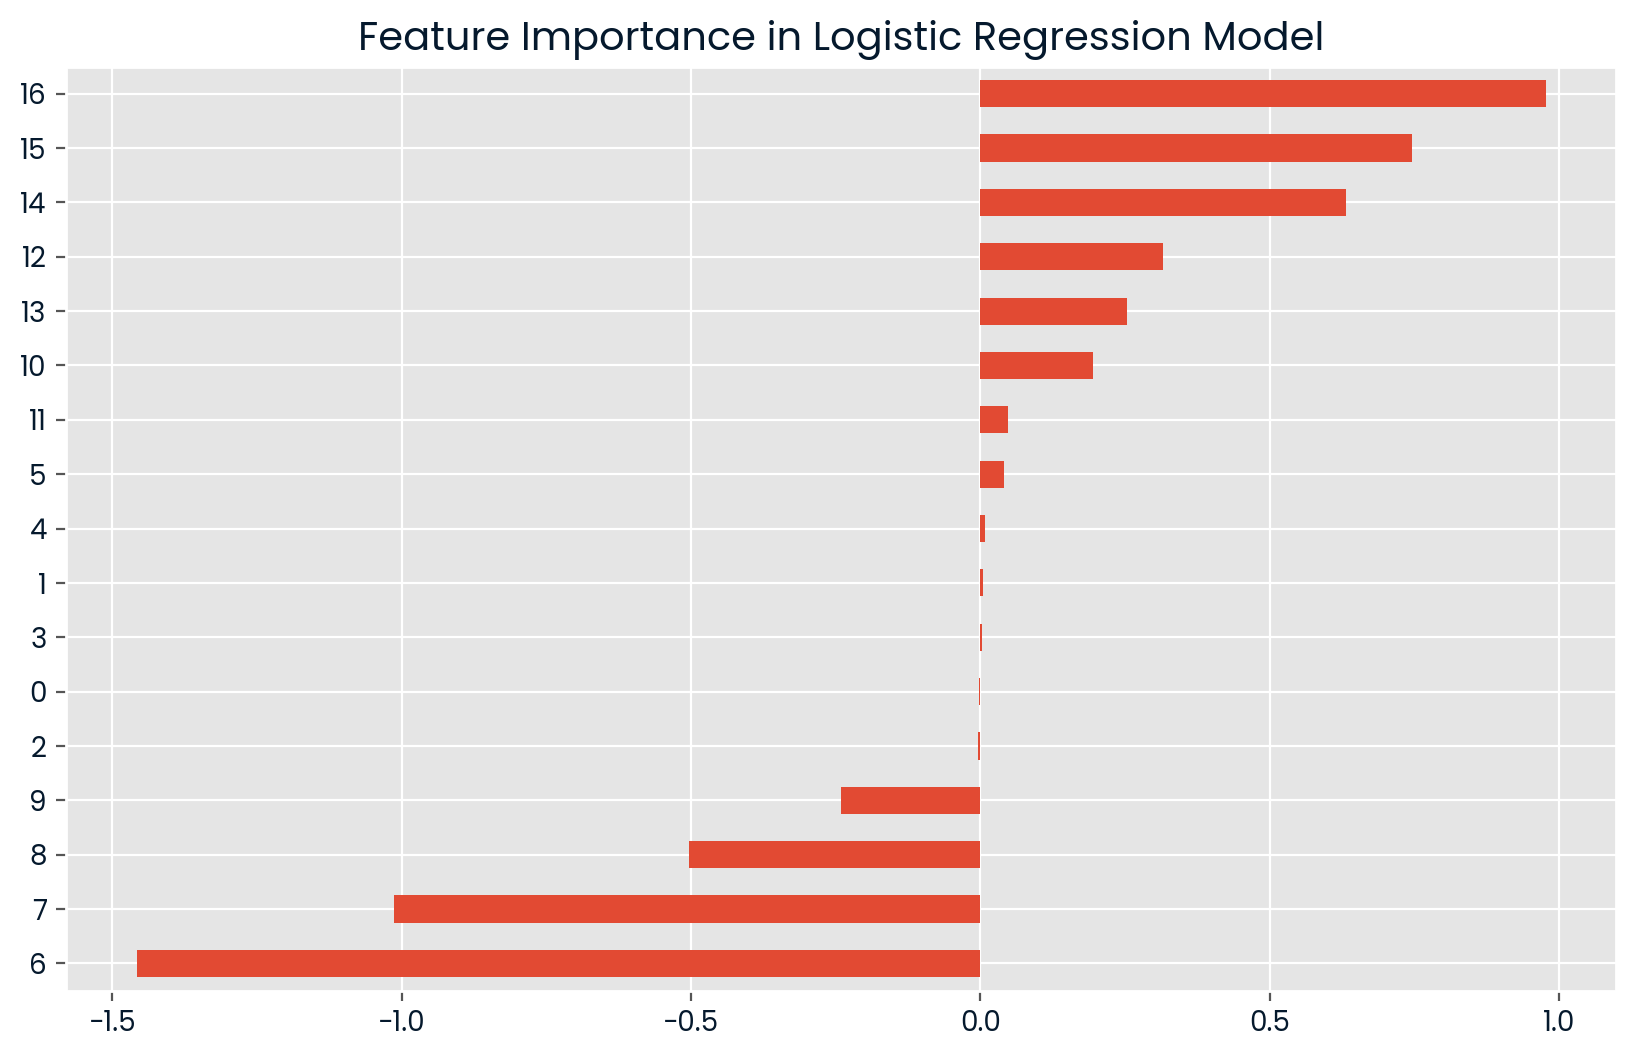

In [265]:
importances = pd.Series(model_lr.coef_[0])
sorted_importances=importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance in Logistic Regression Model')
plt.show()

Now we will implement random forest model and evaluate the result

We will do hyperparametric tuning on max_depth 

In [266]:
df.head()

,calories,carbohydrate,sugar,protein,St_dev,servings,category_Beverages,category_Breakfast,category_Chicken,category_Chicken Breast,category_Dessert,category_Lunch/Snacks,category_Meat,category_One Dish Meal,category_Pork,category_Potato,category_Vegetable,traffic
recipe,,,,,,,,,,,,,,,,,,
2,35.48,38.56,0.660,0.92,18.147933,4,0,0,0,0,0,0,0,0,0,1,0,1
3,914.28,42.68,3.090,2.88,389.210353,1,0,1,0,0,0,0,0,0,0,0,0,0
4,97.03,30.56,21.965,0.02,36.187104,4,1,0,0,0,0,0,0,0,0,0,0,1
5,27.05,1.85,0.800,0.53,11.264798,4,1,0,0,0,0,0,0,0,0,0,0,0
6,691.15,3.46,1.650,53.93,291.511236,2,0,0,0,0,0,0,0,1,0,0,0,1


Random Forest Classifier

Hyperparameteric tining

In [267]:
# define hyperparameter grid
grid = {
    'n_estimators': range(10, 100, 10),
    'max_depth': range(1, 10)
}

# grid cross validate and fit
rfc = RandomForestClassifier(random_state=RAND_STATE)
rfc_cv = GridSearchCV(rfc, grid, cv=cv, scoring=SCORING_METHOD, verbose=1)
rfc_cv.fit(X_train, y_train)

# display results
print(f'Best Score: {rfc_cv.best_score_}')
print(f'Best Hyperparameters: {rfc_cv.best_params_}')
print(f'Std deviation of CV scores for the best hyperparameters: {rfc_cv.cv_results_["std_test_score"][rfc_cv.best_index_]}')


Fitting 10 folds for each of 81 candidates, totalling 810 fits
Best Score: 0.7484289394998321
Best Hyperparameters: {'max_depth': 8, 'n_estimators': 20}
Std deviation of CV scores for the best hyperparameters: 0.04904574434362412


Building final model with best hyperparameters

In [268]:
model_rf = RandomForestClassifier(n_estimators=20, max_depth=8, random_state=RAND_STATE)
model_rf.fit(X_train, y_train)
training_acc= model_rf.score(X_train, y_train)
print(f"Training Score: {training_acc}")
validation_acc = model_rf.score(X_test, y_test)
print(f"Validation Score: {validation_acc}")

Training Score: 0.8547486033519553
Validation Score: 0.6871508379888268


In [269]:
y_pred2 = model_rf.predict(X_test)


In [270]:
print(confusion_matrix(y_test, y_pred2))

[[30 43]
 [13 93]]


In [271]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.41      0.52        73
           1       0.68      0.88      0.77       106

    accuracy                           0.69       179
   macro avg       0.69      0.64      0.64       179
weighted avg       0.69      0.69      0.67       179



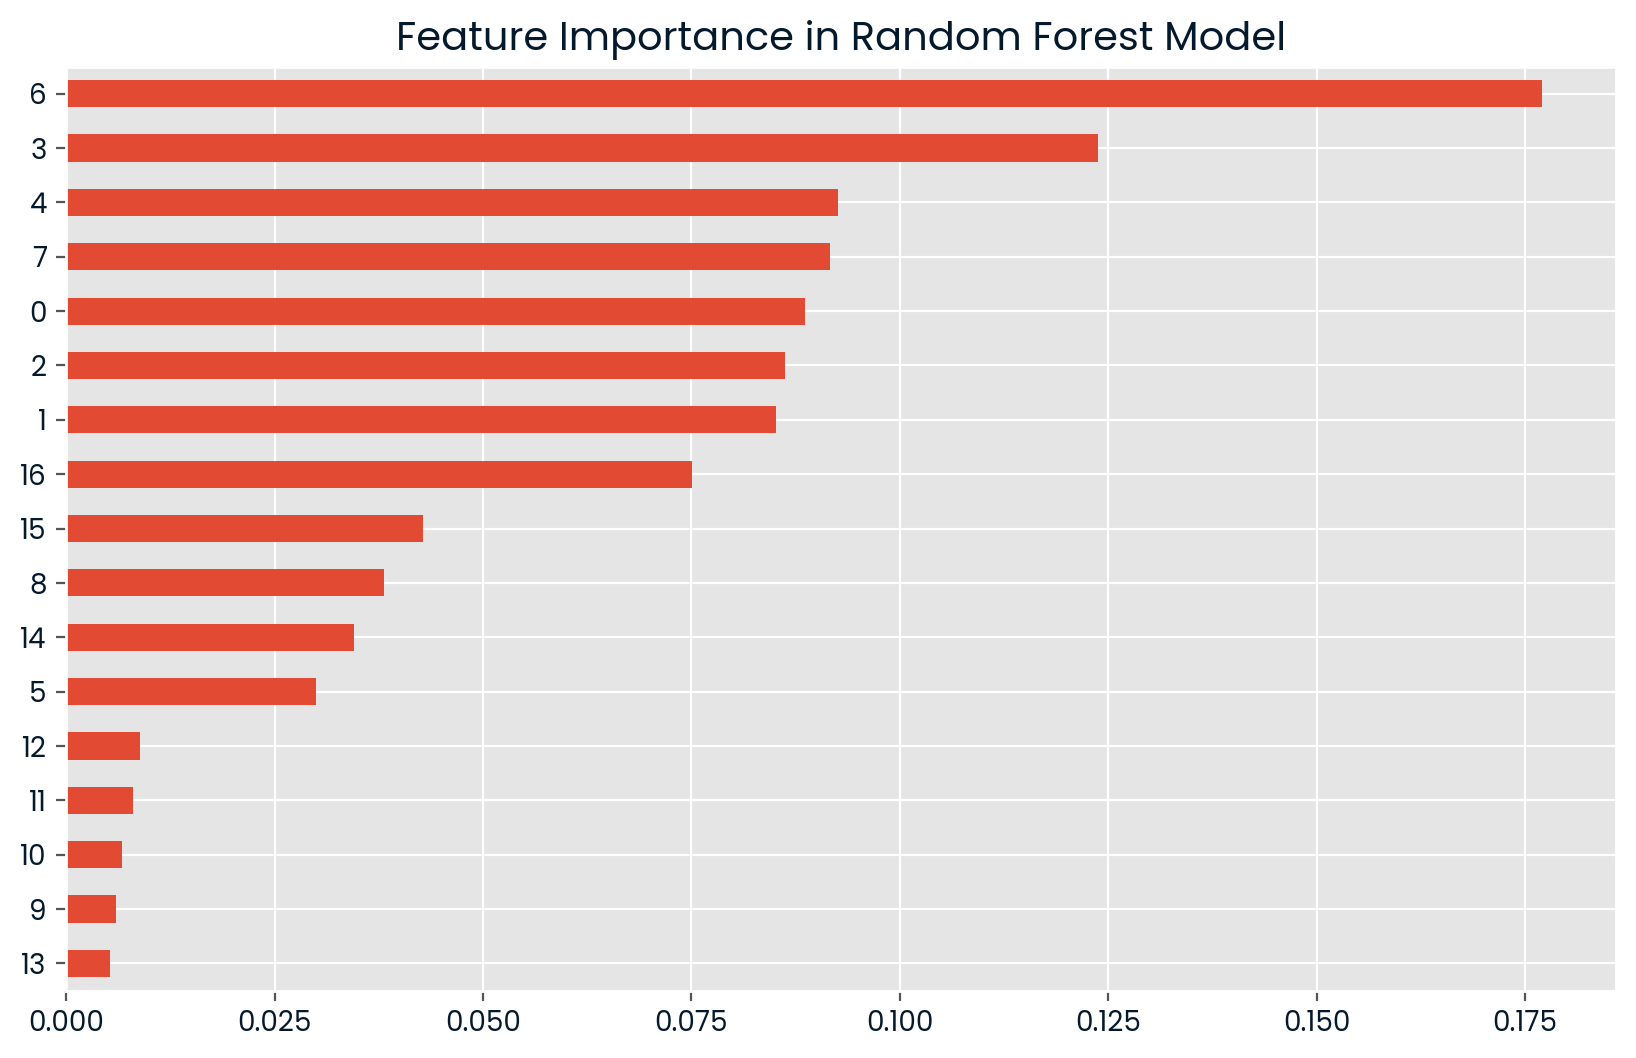

In [272]:
importances = pd.Series(model_rf.feature_importances_)
sorted_importances=importances.sort_values()
plt.figure(figsize=(10, 6))
sorted_importances.plot(kind='barh')
plt.title('Feature Importance in Random Forest Model')
plt.show()

We have better score for logistic regression 

Comparing model accuracies

In [273]:
print(f"Logistic regression testing accuracy: {lr_test_acc}")
print(f"Random Forest tesing accuracy: {validation_acc}")

Logistic regression testing accuracy: 0.75
Random Forest tesing accuracy: 0.6871508379888268


From the above accuracies, we will implement Logistic regression model for better results

**Recommendatioins**

1) Choosing the right model:
        The business should implement the logistic regression model as it has better accuracy.
2) Balance Data Categories: 
        The dataset contains a class imbalance between low and high-traffic recipes. To address this issue,         we suggest collecting additional data for the minority class (low-traffic recipes) or applying data         augmentation techniques to balance the dataset.
3) Focus on low-traffic recipes:
        The business should focus on low traffic recipes in order to convert it into high traffic.
        This can be done by decreasing sugar in the recipes. Chicken, Baverages, and Break Fast has least 
        high traffics. The business should improve the recipe in order to get high traffic.